# Spectral Density Peaks

In [1]:
import numpy as np
from dadapy import Data
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy import special
from scipy.sparse import coo_matrix, diags
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans, SpectralClustering
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import pandas as pd
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
)

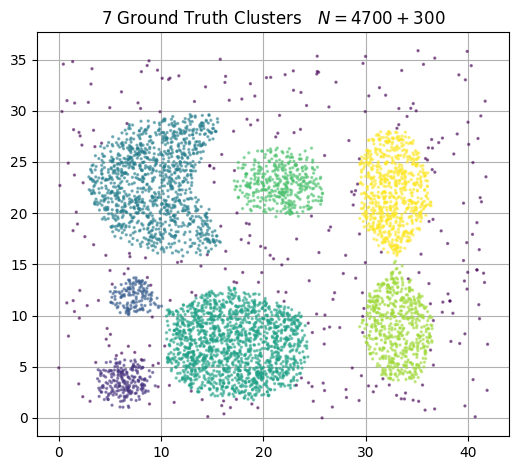

In [2]:
np.random.seed(42)
N_signal = 4700
N_noise = 300
dataset = "S2"
X_path = f"./data/Fig{dataset}.dat"
gt_path = f"./data/gt_F{dataset}.txt"
X = np.genfromtxt(fname=X_path, dtype=np.float64)
gt = np.genfromtxt(fname=gt_path, dtype=np.int8)
signal_mask = gt != -1
noise_mask = gt == -1
signal_size = min(N_signal, signal_mask.sum())
noise_size = min(N_noise, noise_mask.sum())
signal_indices = np.random.choice(
    a=np.where(signal_mask)[0], size=signal_size, replace=False
)
noise_indices = np.random.choice(
    a=np.where(noise_mask)[0], size=noise_size, replace=False
)
indices = np.concatenate((signal_indices, noise_indices), axis=0)
shuffled_indices = np.random.permutation(x=indices)
X = X[shuffled_indices]
gt = gt[shuffled_indices]
data = Data(coordinates=X, verbose=False)
n_gt = len(set(gt)) - 1 + (1 if len(noise_indices) == 0 else 0)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"${n_gt}$ Ground Truth Clusters"
params = rf"$\quad N = {signal_size} + {noise_size}$"
ax.set(aspect="equal", title=title + params)
ax.scatter(x=data.X[:, 0], y=data.X[:, 1], s=2, c=gt, alpha=0.5, zorder=2)
cmap = ax.collections[0].get_cmap()
norm = ax.collections[0].norm
ax.grid()

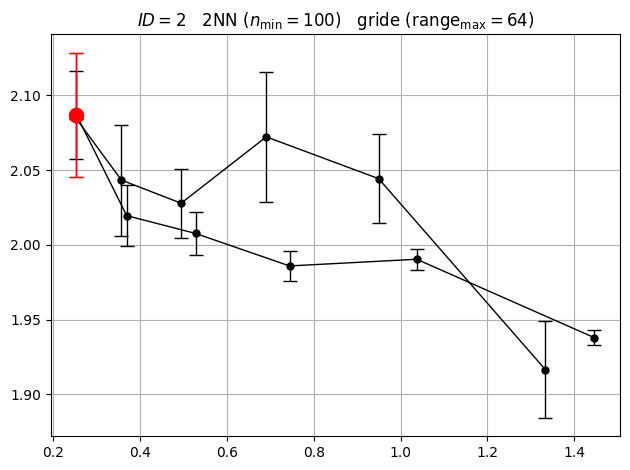

In [3]:
maxk = 1000
algorithms = ["2NN", "gride"]
n_min = 100
range_max = 64
args = {
    "2NN": {"n_min": n_min, "algorithm": "base", "mu_fraction": 0.9, "set_attr": False},
    "gride": {"range_max": range_max, "d0": 0.001, "d1": 1000, "set_attr": False},
}
data.compute_distances(maxk=maxk, metric="euclidean")
intrinsic_dims = {algorithm: None for algorithm in algorithms}
intrinsic_dim_errs = {algorithm: None for algorithm in algorithms}
intrinsic_dim_scales = {algorithm: None for algorithm in algorithms}
for algorithm in algorithms:
    function = f"return_id_scaling_{algorithm}"
    if hasattr(data, function):
        intrinsic_dim_, intrinsic_dim_err_, intrinsic_dim_scale_ = getattr(
            data, function
        )(**args[algorithm])
        intrinsic_dims[algorithm] = intrinsic_dim_
        intrinsic_dim_errs[algorithm] = intrinsic_dim_err_
        intrinsic_dim_scales[algorithm] = intrinsic_dim_scale_
if algorithms == ["2NN", "gride"]:
    closest_scales = np.array(
        object=[
            np.argmin(a=np.abs(intrinsic_dim_scales["2NN"] - intrinsic_dim_scale))
            for intrinsic_dim_scale in intrinsic_dim_scales["gride"]
        ]
    )
    distances = np.abs(intrinsic_dims["2NN"][closest_scales] - intrinsic_dims["gride"])
    errors = np.sqrt(
        intrinsic_dim_errs["2NN"][closest_scales] ** 2
        + intrinsic_dim_errs["gride"] ** 2
    )
    intrinsic_dim_scale = intrinsic_dim_scales["gride"][np.argmin(a=distances / errors)]
    intrinsic_dim_err = np.sqrt(
        intrinsic_dim_errs["gride"][np.argmin(a=distances / errors)] ** 2
        + errors[np.argmin(a=distances / errors)] ** 2
    )
    intrinsic_dim = intrinsic_dims["gride"][np.argmin(a=distances / errors)]
else:
    intrinsic_dim = intrinsic_dims["gride"][0]
    intrinsic_dim_err = intrinsic_dim_errs["gride"][0]
    intrinsic_dim_scale = intrinsic_dim_scales["gride"][0]
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"$ID = {np.round(a=intrinsic_dim):.0f}$"
params = [f"{algorithm}" for algorithm in algorithms]
if "2NN" in params:
    params[params.index("2NN")] += rf" ($n_\text{{min}} = {n_min}$)"
if "gride" in params:
    params[params.index("gride")] += rf" ($\text{{range}}_\text{{max}} = {range_max}$)"
params = r"$\quad$" + r"$\quad$".join(params)
ax.set(aspect="auto", title=title + params)
for algorithm in algorithms:
    ax.errorbar(
        x=intrinsic_dim_scales[algorithm],
        y=intrinsic_dims[algorithm],
        yerr=intrinsic_dim_errs[algorithm],
        fmt="o-",
        markersize=5,
        color="black",
        linewidth=1,
        elinewidth=1,
        capsize=5,
        zorder=2,
    )
    ax.errorbar(
        x=intrinsic_dim_scale,
        y=intrinsic_dim,
        yerr=intrinsic_dim_err,
        fmt="o",
        markersize=10,
        color="red",
        elinewidth=1,
        capsize=5,
        zorder=3,
    )
ax.grid()

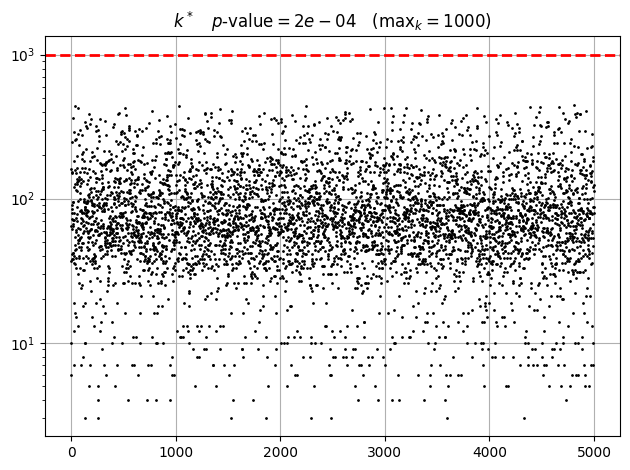

In [4]:
p = 1e-6
p_value = max(1 / data.N, p)
Dthr = chi2.ppf(q=1 - p_value, df=1)
data.set_id(int(np.round(a=intrinsic_dim)))
data.compute_kstar(Dthr=Dthr)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"$k^* \quad p$-value$ = {p_value:.0e}$"
params = rf"$\quad (\text{{max}}_{{k}} = {data.maxk})$"
step = 1000
ax.set(
    aspect="auto", title=title + params, xticks=range(0, data.N + 1, step), yscale="log"
)
ax.scatter(x=range(data.N), y=data.kstar, s=1, c="black", zorder=2)
ax.axhline(y=data.maxk, c="red", ls="--", lw=2, zorder=2)
ax.grid()

In [ ]:
density_estimator = "BMTI"
alpha = 0.7
if density_estimator == "BMTI":
    data.compute_density_BMTI(
        delta_F_inv_cov="LSDI",
        comp_log_den_err="svd",
        solver="sp_cg",
        alpha=alpha,
    )
else:
    _ = data.compute_density_PAk()
fig, axs = plt.subplots(
    ncols=2,
    figsize=(2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1]),
    layout="tight",
)
titles = [rf"$\log\rho$ Distribution", rf"$\log\rho$ Error Distribution"]
if density_estimator == "BMTI":
    titles = [title + rf"$\quad \alpha = {alpha}$" for title in titles]
for ax, estimate, title in zip(axs, [data.log_den, data.log_den_err], titles):
    ax.set(aspect="auto", title=title)
    for label in set(gt):
        ax.hist(
            x=estimate[gt == label],
            density=False,
            color=cmap(norm(label)),
            alpha=0.5,
            zorder=2,
        )
    ax.grid()

recomputing


In [ ]:
H = np.empty_like(prototype=data.distances, dtype=np.float64)
F = np.zeros(shape=data.distances.shape, dtype=np.float64)
H[:, 0] = 0
for i in range(data.N):
    for k in range(1, data.kstar[i]):
        j = data.dist_indices[i, k]
        H[i, k] = data.log_den[i] - data.log_den[j]
        H[i, k] /= np.sqrt(data.log_den_err[i] ** 2 + data.log_den_err[j] ** 2)
        H[i, k] = (1 + special.erf(-H[i, k] / np.sqrt(2))) / 2
n = 0
for i in range(data.N):
    t = 1
    for k in range(1, data.kstar[i]):
        F[i, k] = t * H[i, k]
        t *= 1 - H[i, k]
        n += 1
    normalization = np.sum(F[i, :])
    if normalization != 0:
        F[i, :] /= normalization
row = np.arange(stop=n, step=1)
col = np.arange(stop=n, step=1)
data_ = np.arange(stop=n, step=1, dtype=np.float64)
l = 0
for i in range(data.N):
    for k in range(1, data.kstar[i]):
        data_[l] = F[i, k]
        row[l] = i
        col[l] = data.dist_indices[i, k]
        l += 1
P = coo_matrix(arg1=(data_, (row, col)), shape=(data.N, data.N), dtype=np.float64)
sparsity = 1 - P.nnz / (P.shape[0] * P.shape[1])
print(rf"P Matrix Sparsity: {sparsity:.4f}")

In [ ]:
np.random.seed(42)
k = 7
eps_ratio = 2
k = int(np.cbrt(data.N)) if k is None else max(k, int(np.cbrt(data.N)))
step = int(k / 5)
s = 1 / k * 500
v0 = np.random.rand(data.N)
machine_epsilon = np.finfo(np.float64).eps
with np.errstate(divide="ignore", invalid="ignore"):
    eigenvalues, eigenvectors = eigs(
        A=P, k=k, sigma=1 - machine_epsilon, which="LM", v0=v0
    )
eigenvalues = np.real(val=1 - eigenvalues)
eigenvectors = np.real(val=eigenvectors)
eigenvalue_indeces = np.argsort(a=eigenvalues)
eigenvalues = eigenvalues[eigenvalue_indeces]
eigenvectors = eigenvectors[:, eigenvalue_indeces]
title = rf"First ${k}$ $L$ Eigenvalues"
n_negative = np.argmax(a=eigenvalues > 0)
if n_negative > 0:
    eigenvalues -= eigenvalues[0]
    n_zeros = np.argmax(a=eigenvalues > 0)
    title += rf" (Shifted) $\quad n_0 = {n_zeros}$"
    eps = 10 ** (np.log10(eigenvalues[n_zeros]) - eps_ratio)
fig, axs = plt.subplots(
    ncols=2,
    figsize=(2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1]),
    layout="tight",
)
xticks = range(1, k + step + 1, step)
for ax, yscale in zip(axs, ["linear", "log"]):
    if n_negative > 0 and yscale == "log":
        title += rf"$\quad \varepsilon_0 = {eps:.0e}$"
    ax.set(aspect="auto", title=title, xticks=xticks, yscale=yscale)
    if n_negative > 0:
        if yscale == "log":
            y_ = [eps] * n_zeros + list(eigenvalues[n_zeros:n_negative])
        else:
            y_ = [0] * n_zeros + list(eigenvalues[n_zeros:n_negative])
        ax.scatter(x=range(1, n_negative + 1), y=y_, s=s, c="red", marker="D", zorder=2)
    ax.scatter(
        x=range(1 + n_negative, k + 1),
        y=eigenvalues[n_negative:],
        s=s,
        c="black",
        zorder=2,
    )
    ax.grid()

In [ ]:
k_min = None
if n_negative > 0:
    k_min = n_zeros + 1 if k_min is None else max(n_zeros, k_min)
else:
    k_min = 2
step = max(int((k - k_min) / 5), 1)
s = 1 / (k - k_min) * 500
markersize = np.sqrt(s)
k_range = range(k_min, k)
eigengaps = np.diff(a=eigenvalues)[np.array(object=k_range) - 1]
relative_eigengaps = eigengaps / eigenvalues[np.array(object=k_range) - 1]
optimal_k_values = np.argsort(a=relative_eigengaps)[::-1] + k_min
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"Relative Eigengaps $\quad (k_\text{{min}} = {k_min}$)"
title += rf"$\quad k_\text{{best}} = {optimal_k_values[0]}$"
ax.set(aspect="auto", title=title, xticks=k_range[::step])
ax.plot(
    k_range,
    relative_eigengaps,
    c="black",
    marker="o",
    markersize=markersize,
    linestyle="-",
    linewidth=1,
    zorder=2,
)
ax.scatter(
    x=k_range[optimal_k_values[0] - k_min],
    y=relative_eigengaps[optimal_k_values[0] - k_min],
    s=s,
    c="red",
    marker="D",
    zorder=2,
)
ax.grid()

In [ ]:
n_profiles = optimal_k_values[0] + 3
fig, axs = plt.subplots(
    nrows=n_profiles,
    ncols=2,
    figsize=(
        2 * plt.rcParams["figure.figsize"][0],
        n_profiles * plt.rcParams["figure.figsize"][1],
    ),
    layout="tight",
)
for profile_index in range(n_profiles):
    title = rf"Sorted $L$ Eigenvector ${profile_index + 1}$"
    axs[profile_index, 0].set(aspect="auto", title=title)
    axs[profile_index, 0].plot(
        np.sort(eigenvectors[:, profile_index]), c="black", lw=1, zorder=2
    )
    axs[profile_index, 0].grid()
    title = rf"Density Profile ${profile_index + 1}$"
    axs[profile_index, 1].set(aspect="equal", title=title)
    axs[profile_index, 1].scatter(
        x=data.X[:, 0],
        y=data.X[:, 1],
        s=2,
        c=eigenvectors[:, profile_index],
        alpha=0.5,
        zorder=2,
    )
    axs[profile_index, 1].grid()

In [ ]:
n_clusters = optimal_k_values[0]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(
    X=eigenvectors[:, :n_clusters]
)
density_peaks_indices = {label: None for label in kmeans.labels_}
density_peaks = np.zeros(shape=(n_clusters, data.X.shape[1]), dtype=np.float64)
for index, label in enumerate(range(n_clusters)):
    mask = kmeans.labels_ == label
    subset_index = np.argmax(a=data.log_den[mask])
    parent_index = np.flatnonzero(mask)[subset_index]
    density_peaks_indices[label] = parent_index
    density_peaks[index, :] = data.X[parent_index, :]
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"SDP w/ Density Peaks $\quad {n_clusters}$ Clusters"
ax.set(aspect="equal", title=title)
ax.scatter(x=data.X[:, 0], y=data.X[:, 1], s=2, c=kmeans.labels_, alpha=0.5, zorder=2)
ax.scatter(
    x=density_peaks[:, 0],
    y=density_peaks[:, 1],
    s=100,
    c=list(set(kmeans.labels_)),
    marker="D",
    edgecolors="black",
    zorder=2,
)
ax.grid()

In [ ]:
d = 3 if n_clusters > 2 else 2
fig, axs = plt.subplots(
    ncols=2,
    figsize=(
        2 * plt.rcParams["figure.figsize"][0],
        plt.rcParams["figure.figsize"][1],
    ),
    subplot_kw={"projection": "3d"} if d == 3 else None,
    layout="tight",
)
titles = [
    rf"${d}$-D Projection w/o Noise (Ground Truth)",
    rf"${d}$-D Projection w/ Density Peaks (SDP)",
]
for ax, title, partition in zip(axs, titles, [gt, kmeans.labels_]):
    ax.set(title=title, aspect="auto")
    scatter = ax.scatter if d == 2 else ax.scatter3D
    for label in set(partition) - {-1}:
        scatter(
            *eigenvectors[partition == label, :d].T,
            s=30,
            color=cmap(norm(label)),
            alpha=0.5,
            zorder=2,
        )
        if title == titles[1]:
            scatter(
                *eigenvectors[density_peaks_indices[label], :d].T,
                s=100,
                color=cmap(norm(label)),
                marker="D",
                edgecolors="black",
                alpha=1,
                zorder=2,
            )
    ax.grid()

In [ ]:
np.random.seed(42)
left_k = 5
v0 = np.random.rand(data.N)
with np.errstate(divide="ignore", invalid="ignore"):
    left_eigenvalues, left_eigenvectors = eigs(
        A=P.T, k=left_k, sigma=1 - machine_epsilon, which="LM", v0=v0
    )
left_eigenvalues = np.real(val=left_eigenvalues)
left_eigenvectors = np.real(val=left_eigenvectors)
left_eigenvalue_indeces = np.argsort(a=left_eigenvalues)
left_eigenvalues = left_eigenvalues[left_eigenvalue_indeces]
left_eigenvectors = left_eigenvectors[:, left_eigenvalue_indeces]
n_ones = left_k - np.argmax(a=left_eigenvalues == 1)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"Last ${left_k}$ $P^T$ Eigenvalues"
ax.set(
    aspect="auto",
    title=title,
    xticks=range(data.N - left_k + 1, data.N + 1, 1),
)
ax.scatter(
    x=range(data.N - left_k + 1, data.N - n_ones + 1, 1),
    y=left_eigenvalues[:-n_ones],
    s=40,
    c="black",
    zorder=2,
)
ax.scatter(
    x=range(data.N - n_ones + 1, data.N + 1, 1),
    y=n_ones * [1],
    s=40,
    c="red",
    marker="D",
    zorder=2,
)
ax.grid()

In [ ]:
n_left_profiles = left_k
fig, axs = plt.subplots(
    nrows=n_left_profiles,
    ncols=2,
    figsize=(
        2 * plt.rcParams["figure.figsize"][0],
        n_left_profiles * plt.rcParams["figure.figsize"][1],
    ),
    layout="tight",
)
for profile_index in range(n_left_profiles):
    index = data.N - n_left_profiles + profile_index
    title = rf"Sorted $P^T$ Eigenvector ${index + 1}$"
    axs[profile_index, 0].set(aspect="auto", title=title)
    axs[profile_index, 0].plot(
        np.sort(left_eigenvectors[:, -n_left_profiles + profile_index]),
        c="black",
        lw=1,
        zorder=2,
    )
    axs[profile_index, 0].axhline(y=0, c="red", ls="--", lw=2, zorder=2)
    axs[profile_index, 0].grid()
    title = rf"Density Profile ${index + 1}$"
    axs[profile_index, 1].set(aspect="equal", title=title)
    axs[profile_index, 1].scatter(
        x=data.X[:, 0],
        y=data.X[:, 1],
        s=2,
        c=left_eigenvectors[:, -n_left_profiles + profile_index],
        alpha=0.5,
        zorder=2,
    )
    axs[profile_index, 1].grid()

In [ ]:
stationary_index = -1
q_ = 30
stationary_distribution = left_eigenvectors[:, stationary_index]
stationary_distribution = np.abs(stationary_distribution)
stationary_distribution /= stationary_distribution.sum()
D = diags(diagonals=stationary_distribution, format="coo")
W = (D @ P).tocoo()
W = (W + W.T).tocoo() / 2
G = nx.Graph()
G.add_nodes_from(range(data.N))
w_threshold = np.percentile(a=W.data, q=100 - q_)
for u, v, w in zip(W.row, W.col, W.data):
    if w > w_threshold:
        G.add_edge(u_of_edge=u, v_of_edge=v, weight=w)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"Normalized $W$"
params = rf"$\quad$ Top ${q_:.0f}q$ Non-Zero"
ax.set(aspect="equal", title=title + params)
ax.scatter(x=data.X[:, 0], y=data.X[:, 1], s=2, c=kmeans.labels_, alpha=0.5, zorder=1)
nx.draw_networkx_edges(
    G=G, pos=data.X, width=0.5, edge_color="black", ax=ax, hide_ticks=False
)
ax.set_axisbelow(b=True)
ax.grid()

In [ ]:
Z = 2
_ = data.compute_clustering_ADP(Z=Z, halo=False)
n_resulting = len(set(data.cluster_assignment))
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"ADP w/ Density Peaks"
params = rf"$\quad Z = {Z}$ (${n_resulting}$ Clusters)"
ax.set(aspect="equal", title=title + params)
ax.scatter(
    x=data.X[:, 0], y=data.X[:, 1], s=2, c=data.cluster_assignment, alpha=0.5, zorder=2
)
ax.scatter(
    x=data.X[data.cluster_centers, 0],
    y=data.X[data.cluster_centers, 1],
    s=100,
    c=list(set(data.cluster_assignment)),
    marker="D",
    edgecolors="black",
    zorder=2,
)
ax.grid()

In [ ]:
mode = "distance"
n_neighbors = int(np.floor(np.log(data.N)))
A = kneighbors_graph(
    X=data.X,
    n_neighbors=n_neighbors,
    mode=mode,
    metric="minkowski",
    p=2,
    include_self=False,
)
A = A.maximum(other=A.T).tocoo()
G_ = nx.Graph()
G_.add_nodes_from(range(data.N))
for u, v, w in zip(A.row, A.col, A.data):
    G_.add_edge(u_of_edge=u, v_of_edge=v)
clustering = SpectralClustering(
    n_clusters=n_clusters,
    eigen_solver="arpack",
    assign_labels="kmeans",
    random_state=0,
    n_init=10,
    affinity="precomputed",
).fit(X=A)
fig, axs = plt.subplots(
    ncols=2,
    figsize=(2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1]),
    layout="tight",
)
title = rf"${n_neighbors}$NN Graph"
params = rf"$\quad (\text{{Mode}} = {mode})$"
axs[0].set(aspect="equal", title=title + params)
axs[0].scatter(x=data.X[:, 0], y=data.X[:, 1], s=2, c=gt, alpha=0.5, zorder=1)
nx.draw_networkx_edges(
    G=G_, pos=data.X, width=0.5, edge_color="black", ax=axs[0], hide_ticks=False
)
axs[0].grid()
axs[0].set_axisbelow(b=True)
title = rf"Normalized SC"
params = rf"$\quad {n_clusters}$ Clusters"
axs[1].set(aspect="equal", title=title + params)
axs[1].scatter(
    x=data.X[:, 0], y=data.X[:, 1], s=2, c=clustering.labels_, alpha=0.5, zorder=2
)
axs[1].grid()

In [ ]:
metrics = pd.DataFrame(index=["ARI (w/o Noise)", "NMI (w/o Noise)", "AMI (w/o Noise)"])
methods = {
    "SDP": kmeans.labels_,
    "ADP": data.cluster_assignment,
    "SC": clustering.labels_,
}
for method, labels_pred in methods.items():
    metrics.loc["ARI (w/o Noise)", method] = adjusted_rand_score(
        labels_true=gt[gt != -1], labels_pred=labels_pred[gt != -1]
    )
    metrics.loc["NMI (w/o Noise)", method] = normalized_mutual_info_score(
        labels_true=gt[gt != -1],
        labels_pred=labels_pred[gt != -1],
        average_method="arithmetic",
    )
    metrics.loc["AMI (w/o Noise)", method] = adjusted_mutual_info_score(
        labels_true=gt[gt != -1],
        labels_pred=labels_pred[gt != -1],
        average_method="arithmetic",
    )
highlight = lambda row: ["color: green" if value == row.max() else "" for value in row]
display(metrics.style.apply(func=highlight, axis=1).format("{:.3f}"))